In [13]:

# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [16]:
def subtract_from_prev_val(df, col, init_val=0):
    return (df[col] - df.shift()[col])
    
def integrate_col(df, fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = df[fxdx_col].tolist()
    dx_l = df[dx_col].tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * fxdx_l[i]
        y[i] = y_val
        prev_val = y_val
        
    return np.array(y)

In [14]:
GYRO_COEF = 16.4# the scale factor represents the sensitivy factor applied to the sensor. 
                # divide by 131 to get degrees per second


In [17]:
df = pd.read_csv('data/left_test_03.csv')
df_orig = df.copy()
# remove drift..
for gaxis in ['gx', 'gy', 'gz']:
    df[gaxis] = df[gaxis] / GYRO_COEF
df['time_diff'] = subtract_from_prev_val(df, 'timestamp').fillna(0)/1000
df['theta'] = integrate_col(df, 'gz', 'time_diff', 0)

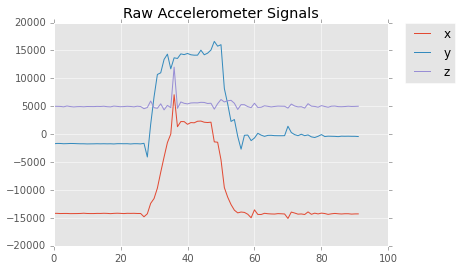

In [18]:
plt.plot(df['ax'], label='x')
plt.plot(df['ay'], label='y')
plt.plot(df['az'], label='z')
plt.title('Raw Accelerometer Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

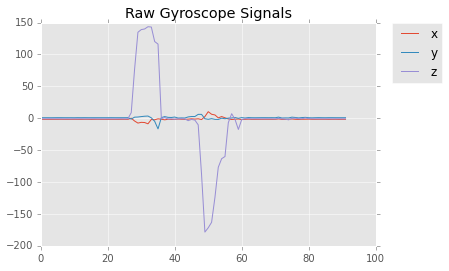

In [19]:
plt.plot(df['gx'], label='x')
plt.plot(df['gy'], label='y')
plt.plot(df['gz'], label='z')
plt.title('Raw Gyroscope Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

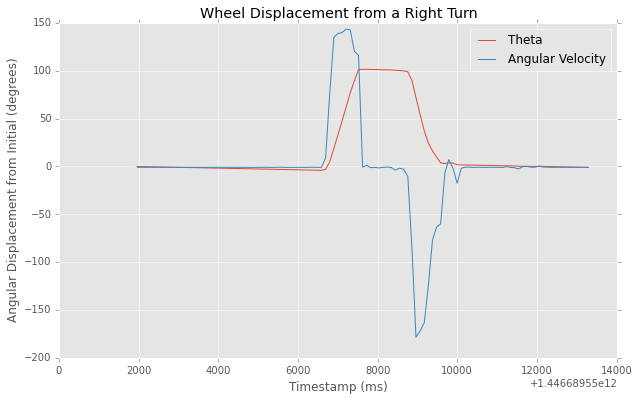

In [38]:
plt.figure().set_size_inches(10, 6)
plt.plot(df['timestamp'], df['theta'], label='Theta')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Angular Displacement from Initial (degrees)')
plt.title('Wheel Displacement from a Right Turn')
plt.plot(df['timestamp'], df['gz'], label='Angular Velocity')
plt.legend()

In [775]:
max(df.theta) + np.abs(min(df.theta))

101.84945927137997

# Calculate Left Turn Events

In [782]:
import Queue
def calculate_events(positions, time_stamps, threshold = 10, window_size = 5):
    """
    Calculates the events that occured from the wheel turns
    positions - list of positions
    threshold - error in position, unit is in degrees
    """
    starting_value = positions[0]
    rolling_avg = starting_value
    q = Queue.Queue()
    q.put(starting_value)
    events = []
    is_event = False
    max_mag = 0
    current_event = {}
    for i in xrange(len(positions)):
        p = positions[i]
        if q.qsize() == window_size:
            rolling_avg = (rolling_avg * window_size - q.get()) / q.qsize()

        
        rolling_avg = (rolling_avg * q.qsize() + p) / window_size
        q.put(p)
        max_mag = np.abs(rolling_avg) if np.abs(rolling_avg) > max_mag else max_mag
        if np.abs(rolling_avg) > (starting_value + threshold):
            # wheel position is away from starting and an event is occuring
            if rolling_avg > 0:
                if not is_event:
                    is_event = True
                    current_event['start_time'] = time_stamps[i]
                    current_event['event'] = 1.0 #'left turn'
            if rolling_avg < 0:
                if not is_event:
                    is_event = False
                    current_event['start_time'] = time_stamps[i]
                    current_event['event'] = 2.0 #'right turn'
        else:
            # wheel is within starting position
            if is_event and np.abs(rolling_avg) < (starting_value + threshold):
                is_event = False
                current_event['end_time'] = time_stamps[i]
                current_event['max_mag'] = max_mag
                events.append(current_event.copy())
                current_event = {}
                max_mag = 0
                
    return pd.DataFrame(events)
        

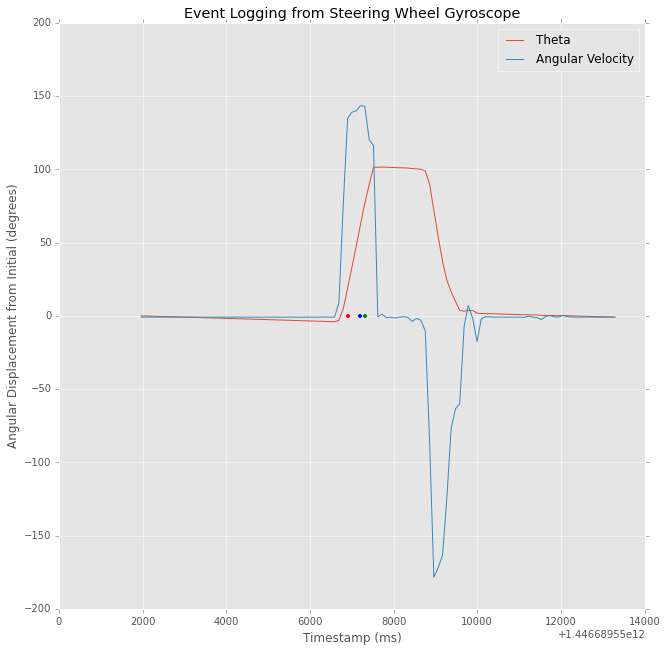

In [799]:
# def plot_events(df, theta, angular_speed, window_size):
    
#     events = calculate_events(df[theta].tolist(), df['timestamp'].tolist(), window_size=window_size)
#     plt.plot(df['timestamp'], integrate_col(df, angular_speed, 'time_diff', 0))
#     plt.plot(df['timestamp'], df[angular_speed])
#     plt.scatter(events['start_time'], [0]*len(events), c =[1]*len(events))
# plt.scatter(events['end_time'], [0]*len(events), c = events['event'])
plt.figure().set_size_inches(10.5, 10.5)
plt.plot(df['timestamp'], integrate_col(df, 'gz', 'time_diff', 0), label = 'Theta')
plt.plot(df['timestamp'], df['gz'], label='Angular Velocity')
plt.legend()
plt.xlabel('Timestamp (ms)')
plt.ylabel('Angular Displacement from Initial (degrees)')
plt.title('Event Logging from Steering Wheel Gyroscope')
events = calculate_events(df['theta'].tolist(), df['timestamp'].tolist(), window_size=2)
plt.scatter(events['start_time'], [0]*len(events), c =['red']*len(events))
events = calculate_events(df['theta'].tolist(), df['timestamp'].tolist(), window_size=10)
plt.scatter(events['start_time'], [0]*len(events), c =['blue']*len(events))

events = calculate_events(df['theta'].tolist(), df['timestamp'].tolist(), window_size=20)
plt.scatter(events['start_time'], [0]*len(events), c =['green']*len(events))
# plot_events(df, 'theta', 'gz', 10)
# plot_events(df, 'theta', 'gz', 2)

In [786]:
events

""


$$ SE = \sum_{i=0}^{N}(\theta_{true} - \theta_{approximate})^2 / (N-1)  $$

$$ Metric = \sum_{i=0}^{N} (I(NoNullColumns)) / N $$

$$ Consistent SE = \sum_{i=0}^{N}(SampleRate_{measured} - SampleRate_{theoretical})^2 / (N-1)  $$

In [530]:
events

,end_time,event,max_mag,start_time
0,1.446442e+12,1,68.515177,1.446442e+12
